# Scalable Diffusion Models with Transformer (DiT)

This notebook samples from pre-trained DiT models. DiTs are class-conditional latent diffusion models trained on ImageNet that use transformers in place of U-Nets as the DDPM backbone. DiT outperforms all prior diffusion models on the ImageNet benchmarks.

[Project Page](https://www.wpeebles.com/DiT) | [HuggingFace Space](https://huggingface.co/spaces/wpeebles/DiT) | [Paper](http://arxiv.org/abs/2212.09748) | [GitHub](github.com/facebookresearch/DiT)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the DiT GitHub repo and setup PyTorch. You only have to run this once.

In [1]:
import os
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_S_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

c:\Users\wg19671\AppData\Local\anaconda3\envs\propainter\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


# Download DiT-XL/2 Models

You can choose between a 512x512 model and a 256x256 model. You can swap-out the LDM VAE, too.

In [14]:
image_size = 256 #@param [256, 512]
dtype = torch.float32 #@param [torch.float16, torch.float32, torch.bfloat16]
num_classes = 1000 #@param [100, 1000]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8

# Load model:
model = DiT_S_2(
    input_size=latent_size,
    num_classes=num_classes,
    enable_flashattn=False,
    dtype=dtype
).to(device).to(dtype)
state_dict = find_model("C:/Users/wg19671/Downloads/DiT/results/002-DiT-S-2/checkpoints/0010000.pt")
# state_dict = find_model("C:/Users/wg19671/Downloads/DiT/pretrained_models/0001000.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

# 2. Sample from Pre-trained DiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [15]:

num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 7 #@param {type:"slider", min:1, max:10, step:0.1}
# class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
class_labels = tuple(map(int, torch.randint(0, 1000, (8,)).tolist()))
print(class_labels)

# Set user inputs:
seed = -1 #@param {type:"number"}
torch.manual_seed(seed)
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device).to(dtype)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([100] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)
print(z.shape, y.shape)


(617, 914, 757, 545, 967, 915, 288, 203)
torch.Size([16, 4, 32, 32]) torch.Size([16])


In [73]:
import torchvision.io as io
import torchvision.transforms as transforms

img = io.read_image("C:/Users/wg19671/Downloads/DiT/data/images/test/3096.jpg")
img2 = io.read_image("C:/Users/wg19671/Downloads/DiT/data/images/test/97033.jpg")
print(f"{img.shape = }")
img_batch = torch.stack([img, img2], 0).to(device).to(dtype)

trsfrm = transforms.Compose([
    transforms.Resize((240, 432)),
])

img_batch = trsfrm(img_batch)

print(f"{img_batch.shape = }")

img_batch_latent = vae.encode(img_batch.to(device).to(dtype))
print(img_batch_latent.latent_dist.sample().mul_(0.18215).shape)


img_recon = vae.decode(img_batch_latent.latent_dist.sample().mul_(0.18215))

img.shape = torch.Size([3, 321, 481])
img_batch.shape = torch.Size([2, 3, 240, 432])
torch.Size([2, 4, 30, 54])


In [69]:
img_recon

DecoderOutput(sample=tensor([[[[ 0.3430,  0.2988,  0.3068,  ...,  0.3701,  0.3558,  0.3442],
          [ 0.3013,  0.3114,  0.2995,  ...,  0.3711,  0.3568,  0.3062],
          [ 0.2967,  0.2827,  0.2804,  ...,  0.3237,  0.3070,  0.3526],
          ...,
          [ 0.2038,  0.1938,  0.1916,  ...,  0.3294,  0.3119,  0.3450],
          [ 0.2138,  0.2033,  0.1956,  ...,  0.3362,  0.3301,  0.3504],
          [ 0.2081,  0.1556,  0.1584,  ...,  0.2864,  0.2958,  0.3234]],

         [[ 0.2862,  0.2444,  0.2536,  ...,  0.2557,  0.2379,  0.2402],
          [ 0.2630,  0.2661,  0.2560,  ...,  0.2627,  0.2584,  0.1750],
          [ 0.2579,  0.2432,  0.2387,  ...,  0.2161,  0.2254,  0.2277],
          ...,
          [ 0.1328,  0.1069,  0.1192,  ...,  0.1681,  0.1571,  0.1579],
          [ 0.1708,  0.1497,  0.1220,  ...,  0.1736,  0.1505,  0.1252],
          [ 0.1095,  0.0648,  0.0572,  ...,  0.1131,  0.1156,  0.1318]],

         [[ 0.1945,  0.1324,  0.1370,  ...,  0.0886,  0.0582,  0.0318],
         

100%|██████████| 250/250 [00:01<00:00, 143.68it/s]


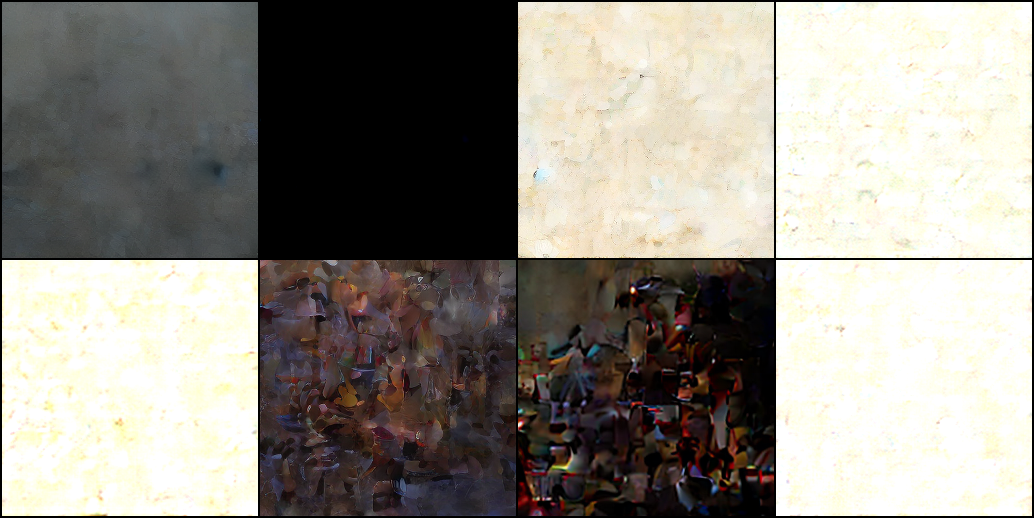

In [28]:
# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)